# Nobel Twin Cirrhosis Machine Learning Analysis
This notebook looks to perform machine learning analysis using a biologically relevant feature set. The biologically relevant feature set is composed of metabolomic direct parents that have been identified to be changing with disease progression and have scientific literature to back up these changes. The subclasses we are going to look into are: glycinated bile acids and some specific phosphocholines. I will start with a feature set that contains all features with this classification and iteratively whittle down the feature set to improve the model if necessary. I will look into both Logistic Regression and Random Forest while using ROC and Precision-Recall as a test for accuracy.

**Author: Tobin Groth (tgroth@ucsd.edu)**


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import qiime2
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pylab as pl
import qiime2
import os


os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/serum_analysis')

In [2]:
#loading in fecal metadata
meta = pd.read_csv('../metadata-matched.tsv',sep='\t',index_col=0)
meta.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [3]:
#loading in the hashed+scaled feature table
serum_table = qiime2.Artifact.load('feature_tables/serum-ft-hashed-matched-scaled.qza')
serum_tablepd = serum_table.view(pd.DataFrame)
serum_tablepd.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,fe8cbb81d1abec83ba4cc2e9f82dd552,febe3e034a4a2cb784dec089610dd34c,fecd9732b400a12637130cb39f076b17,ff0f37b5dc7b583b0990818a3ca3bd85,ff47eed94e12e32213900023846a2b25,fface4fa9e4315823b284edf46814f27,ffc858cfa01fda2a2b2c0a1344a0b87a,ffe5d35f6eb7b6d40c0b901f6576ca3c,ffeb115b9cba8e7fde3b05c27b47a913,fff8ef7ac71077d6ddc2c538ad270385
TW-CO-002,1.057551,0.713690,0.101371,0.133053,-0.286215,-0.318617,0.065534,-0.279881,0.117167,-0.301339,...,-0.719733,0.180132,-0.325997,-0.386096,-0.095690,-0.185462,-0.174831,-0.072250,0.065709,-0.985989
TW-BT-001,4.324877,3.217350,-0.021519,3.134937,6.154245,-0.316190,4.300775,0.274048,0.371661,-0.301339,...,-0.719733,1.366283,0.741181,-0.301068,-0.138150,-0.185047,-0.174998,0.048797,7.210811,-0.985989
TW-CA-002,-0.503911,0.362269,-0.075956,1.604561,0.699963,-0.318680,0.459769,0.823721,0.202315,-0.280759,...,-0.719733,1.618091,1.256980,-0.390866,-0.189908,-0.185924,6.574866,0.513861,-0.336444,-0.985989


In [7]:
#loading in feature taxonomy
serum_data = pd.read_csv('./classified-feature-data.tsv',sep='\t',index_col=0)
print(serum_data.shape)
serum_data.head(3)

(1847, 13)


,#featureID,csi_smiles,ms2_smiles,ms2_compound,ms2_adduct,table_number,smiles,annotation_type,kingdom,superclass,class,subclass,direct_parent
id,,,,,,,,,,,,,
da5dc9007216de85908619b0d8d6c065,395,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,NaN,NaN,NaN,1,CCCCCCCCCCC(=NC(CCCNC(=N)N)C(=NC(CC1=CC=CC=C1)...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
b5a7b5651a9dd589ebba875701732d11,4673,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,NaN,NaN,NaN,1,CCCCCC=CCC=CCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N...,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified
5a307cd7a787f5b3269a7d6c0175fb2e,2513,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,NaN,NaN,NaN,1,CCC(C(C(CO)N(C)CC(C(C(C(C(CO)O)O)O)O)O)O)O,CSIFingerID,unclassified,unclassified,unclassified,unclassified,unclassified


In [10]:
#creating taxa table made up of biologically relevant direct parents
pc1 = '1-alkyl,2-acetylglycero-3-phosphocholines'
pc2 = '1-acyl-sn-glycero-3-phosphocholines'
gba = 'Glycinated bile acids and derivatives'
feat_dp = [pc1,pc2,gba]
feat_keep = []
for idx in serum_data.index:
    if serum_data.loc[idx].direct_parent in feat_dp:
        feat_keep.append(idx)
#making taxonomy table of features we want
bio_rev_taxa = serum_data.loc[feat_keep]
bio_rev_taxa.direct_parent.value_counts()

1-acyl-sn-glycero-3-phosphocholines          96
Glycinated bile acids and derivatives        25
1-alkyl,2-acetylglycero-3-phosphocholines     6
Name: direct_parent, dtype: int64

In [11]:
# creating feature table made of biologically relevant features
bio_rev_table = serum_tablepd.loc[:,feat_keep]
print(bio_rev_table.shape)
bio_rev_table.head(3)

(167, 127)


,498af6ef399e0766ab141f7e0850f255,3ac702470bdecf92714403e2c2be2db1,bafe40841caf7a8373bdad20d3e520f3,cfbf88b2bdbe9d068a2852e94b20c5d4,35ebb42e0baffb034b6503a376fa3ab3,4fe4342087069d7cab2093cf396ee372,55b4046e9e5bbe84fecc12ef95857806,83e0149529ff30f4a5f6ab4ee19ebfc7,20d706e9b1f9ee23f15654c17fb072c6,0f4e391b192f212ada69b4850e011264,...,e41396250e6f3845651ef75b062f94c7,c4239aeefef733c0631cc013a15025f8,0b7e8480475531df848e9b00631d5f4d,e4638e6dd2b4c354eccea183f0aee9f1,e4b50b5c42062031ad519ff0d0ad0891,676fd09c2c49facd99d288baa04d9a8a,26c5d838136d5ac17e2ce59e3ab46bc5,1e30f92443d9403dbf2b33f6ac72a64e,87d954d5783b07022ab2d4de86a538fc,75a51f7c70cb8d6f4fed2be4a640e028
TW-CO-002,-0.716042,-0.403762,0.970533,-0.019032,0.180565,-0.016867,-0.515602,-0.985617,-0.155850,-0.614237,...,-0.551299,0.399452,-0.579624,-0.110750,-0.141496,-0.303890,-0.118065,0.396872,-0.361004,0.934971
TW-BT-001,-0.715662,-0.394864,1.112215,11.288922,-0.265106,-0.235397,3.105470,-0.381861,3.126522,-0.614702,...,-0.513131,1.832282,-0.575901,-0.160327,0.130763,-0.296301,-0.112797,0.367938,-0.399795,-0.350390
TW-CA-002,-0.715434,-0.414313,0.925876,0.457623,0.305845,-0.058460,0.504413,-0.191661,1.191594,-0.612633,...,-0.529386,0.913956,-0.584720,-0.230698,0.363006,-0.300596,-0.119735,0.576328,-0.396506,0.033699


In [12]:
#export the list of full features
with open('./ml_analysis/bioRev_analysis/bio-rev-features-full.txt', 'w') as f:
    for item in bio_rev_table.columns:
        f.write("%s\n" % item)

## 1. Building Models From Full Bio Rev Feature Table

### 1a. CV/Train Models on non-NAFLD (G1P) and NAFLD-cirrhosis (G3P) probands

In [13]:
# get all the samples that are either in group G1P G3P
train_samples = ([idx for idx in meta[meta.ATTRIBUTE_groups=='G1P'].index]
            + [idx for idx in meta[meta.ATTRIBUTE_groups=='G3P'].index])
train_table = meta.loc[train_samples][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
train_table.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
print(train_table.groups.value_counts())
print(train_table.adv_fibrosis.value_counts())

G1P    48
G3P    22
Name: groups, dtype: int64
0                         44
1                         22
Missing: Not collected     4
Name: adv_fibrosis, dtype: int64


In [14]:
#preparing training data for SB top 50
x_train = bio_rev_table.loc[train_table.index]
#label encoder
y_train = []
for idx in train_table.index:
    if train_table.loc[idx,'adv_fibrosis'] == '1':
        y_train.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train.append(0)
y_train = np.array(y_train)
print(len(x_train.index))
print(len(y_train))

70
70


In [15]:
#creating method for cross validating model by plotting ROC
#cf==0 for log reg, cf==1 for RF
def cross_val_roc(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    
    fig = plt.figure()
    ax = plt.subplot(111)

    # Run classifier with crossvalidation and plot ROC curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' %  roc_auc)

    plt.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Luck')
    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return plt

In [16]:
#creating method for cross validating model by plotting Precision-Recall curve
#cf==0 for log reg, cf==1 for RF
def cross_val_pr(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot precision-recall curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.4, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_precision = 0.0
    mean_recall = np.linspace(1, 0, 100)
    all_precision = []

    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute precision-recall curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y_train[test], probas_[:,1])
        #fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        rev_recall = recall[::-1]
        rev_precision = precision[::-1]
        mp = np.interp(mean_recall, rev_recall, rev_precision)
        #print(mp)
        mean_precision += mp
        #mean_precision[0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.2f)' %  pr_auc)

    #plt.plot([0, 1], [1, 0], '--', color=(0.6,0.6,0.6), label='Luck')

    mean_precision /= cv.get_n_splits()
    #mean_precision[-1] = 1.0
    mean_auc = auc(mean_recall, mean_precision)
    #print(mean_recall)
    #print(mean_precision)
    plt.plot(mean_recall, mean_precision, 'k--',
            label='Mean Precision-Recall (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    #plt.legend(loc="lower right")
    return plt

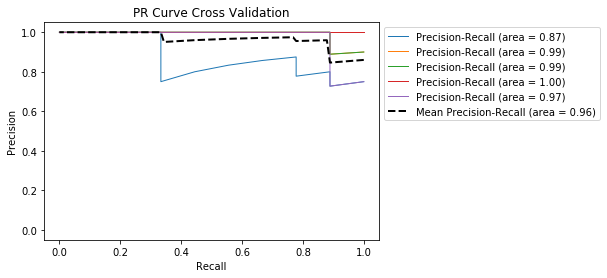

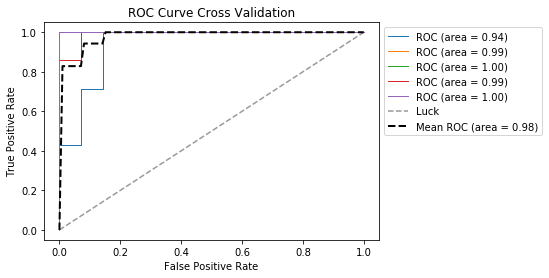

In [17]:
#plotting Precision-recall/ROC for Log Reg
fig_lr = cross_val_pr(0,x_train,y_train,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bio_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train,y_train,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bio_cv_roc.pdf',bbox_inches='tight')

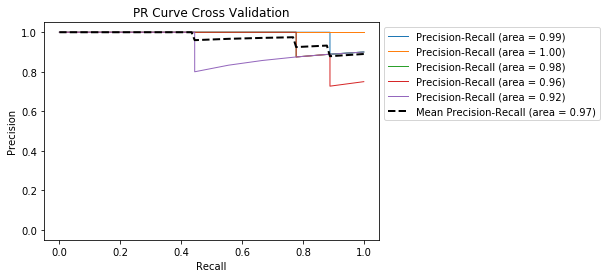

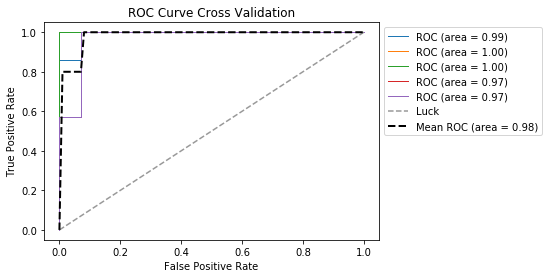

In [18]:
#plotting Precision-recall/ROC for Random Forest
fig_rf = cross_val_pr(1,x_train,y_train,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bio_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train,y_train,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bio_cv_roc.pdf',bbox_inches='tight')

In [19]:
#training Log Reg on training data
full_lr = LogisticRegression(random_state=0,max_iter=200)
full_lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
#training RF on training data
full_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
full_rf.fit(x_train, y_train)
full_rf.oob_score_

0.9285714285714286

### 1b. Testing Models on NAFLD-cirrhosis Relatives (G3R)

In [22]:
# get all the samples that are G3R
test_samples = [idx for idx in meta[meta.ATTRIBUTE_groups=='G3R'].index if idx in serum_tablepd.index]
test_table = meta.loc[test_samples][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
test_table.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
#have to drop Missing: Not collected values
test_table = test_table[test_table.adv_fibrosis != 'Missing: Not collected']
print(test_table.adv_fibrosis.value_counts())

0    21
1     7
Name: adv_fibrosis, dtype: int64


In [23]:
# Preparing the test data for SB
x_test = bio_rev_table.loc[test_table.index]
y_test = []
for idx in test_table.index:
    if test_table.loc[idx,'adv_fibrosis'] == '1':
        y_test.append(1)
    elif test_table.loc[idx,'adv_fibrosis'] == '0':
        y_test.append(0)
y_test = np.array(y_test)
print(len(x_test))
print(len(y_test))

28
28


In [24]:
#plotting Precision Recall curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_pr(result,title,cv=True):
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    #ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_recall = np.linspace(1, 0, 100)
    for cls in classes:
        precisions = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
                rev_recall = recall[::-1]
                rev_precision = precision[::-1]
                mean_precision = np.interp(mean_recall, rev_recall, rev_precision)
                precisions.append(mean_precision)
                precisions[-1][0] = 0.0
                pr_auc = metrics.auc(mean_recall, mean_precision)
                aucs.append(pr_auc)

            mean_precision = np.mean(precisions, axis=0)
            #mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_recall, mean_precision, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_precision = np.std(precisions, axis=0)
            precisions_upper = np.minimum(mean_precision + std_precision, 1)
            precisions_lower = np.maximum(mean_precision - std_precision, 0)
            ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
            pr_auc = auc(recall, precision)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(recall, 0, 0), np.insert(precision, 0, 0), label='{0} ({1:.2f})'.format(cls, pr_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else pr_auc
    return plt

In [25]:
#plotting ROC curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_roc(result,title,cv=True):    
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = metrics.roc_curve(y_true.astype(int), df[cls])
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = metrics.auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else roc_auc
    return plt

In [26]:
#testing the logistic regression full model
result_full_lr = pd.DataFrame(full_lr.predict_proba(x_test))
result_full_lr.columns = full_lr.classes_
result_full_lr['Y_TRUE'] = y_test
result_full_lr['CV'] = 0

Average precision-recall score: 0.27


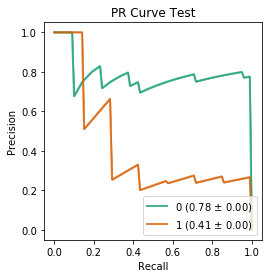

In [27]:
#plotting Log Reg results as Precision Recall curve
fig_lr = plot_result_pr(result_full_lr,'PR Curve Test')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bio_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test, full_lr.predict(x_test))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


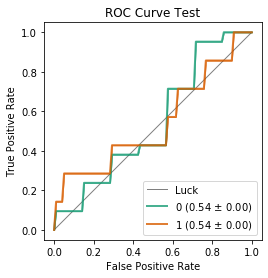

In [28]:
#plotting Log Reg results as ROC
fig_lr = plot_result_roc(result_full_lr,'ROC Curve Test')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bio_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test, full_lr.predict(x_test))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [29]:
#testing the Random Forest full model
result_full_rf = pd.DataFrame(full_rf.predict_proba(x_test))
result_full_rf.columns = full_rf.classes_
result_full_rf['Y_TRUE'] = y_test
result_full_rf['CV'] = 0

Average precision-recall score: 0.27


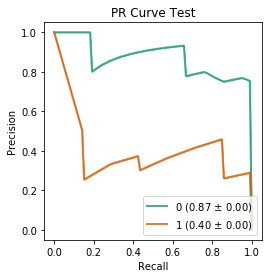

In [30]:
#plotting RF results as Precision Recall curve
fig_rf = plot_result_pr(result_full_rf,'PR Curve Test')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bio_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test, full_rf.predict(x_test))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.39


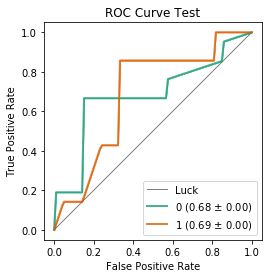

In [31]:
#plotting results as ROC
fig_rf = plot_result_roc(result_full_rf,'ROC Curve Test')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bio_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test, full_rf.predict(x_test))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

**Using Feature Importance to Extract Features for Model Improvment**

In [32]:
# extracting the important features from our classifier
feat_imp1 = pd.Series(full_rf.feature_importances_).sort_values(ascending=False)
feat_imp1 = feat_imp1.to_frame()
feat_imp1.columns = ['imp_score']
feat_imp1.head(3)

,imp_score
67,0.092795
25,0.066564
125,0.066410


In [33]:
# extracting the features that have a feature importance over the threshold of 0.005
top_feat1 = list(feat_imp1[feat_imp1['imp_score']>0.005].index)
#changing feature index from index location to proper feature hash val
feat1_table = bio_rev_table.iloc[:,top_feat1]
print('There are %d features with importance >0.005' %len(feat1_table.columns))

There are 45 features with importance >0.005


In [34]:
#export the list of full features
with open('./ml_analysis/bioRev_analysis/bio-rev-features-sel.txt', 'w') as f:
    for item in feat1_table.columns:
        f.write("%s\n" % item)

## 2. Building Models on Selected Features

### 2a. CV/Train Models on non-NAFLD and NAFLD-cirrhosis probands (G1P+G3P)

In [39]:
#preparing training data for Bio sel
x_train_sel = feat1_table.loc[train_table.index]
#label encoder
y_train_sel = []
for idx in train_table.index:
    if train_table.loc[idx,'adv_fibrosis'] == '1':
        y_train_sel.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_sel.append(0)
y_train_sel = np.array(y_train_sel)
print(x_train_sel.shape)
print(len(y_train_sel))

(70, 45)
70


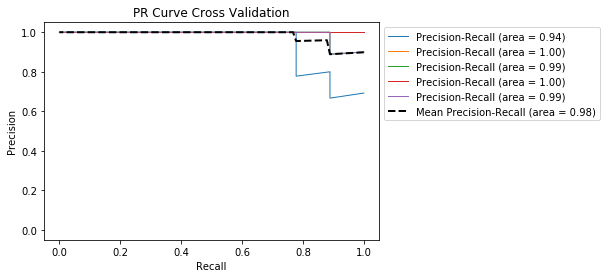

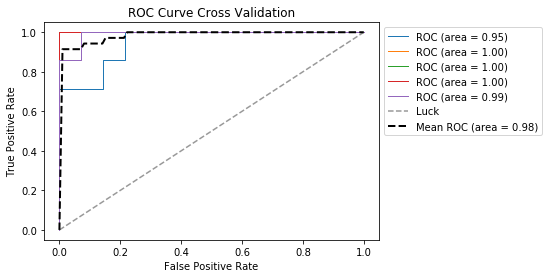

In [36]:
#plotting Precision-recall/ROC for Log Reg
fig_lr = cross_val_pr(0,x_train_sel,y_train_sel,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioSel_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_sel,y_train_sel,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioSel_cv_roc.pdf',bbox_inches='tight')


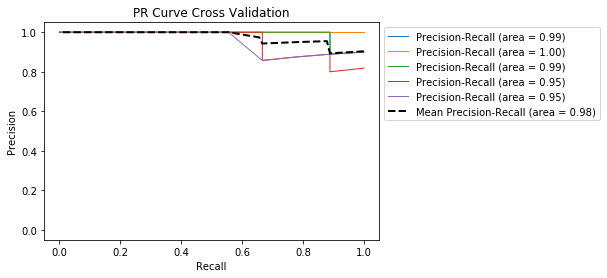

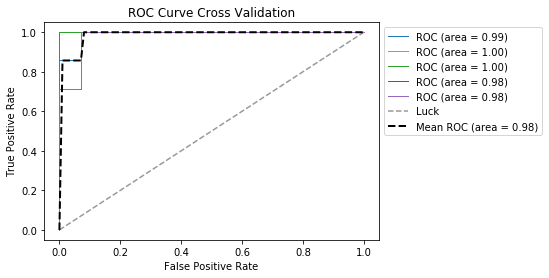

In [37]:
#plotting Precision-recall/ROC for RF
fig_rf = cross_val_pr(1,x_train_sel,y_train_sel,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioSel_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_sel,y_train_sel,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioSel_cv_roc.pdf',bbox_inches='tight')


In [40]:
#training Log Reg on training data
feat1_lr = LogisticRegression(random_state=0,max_iter=200)
feat1_lr.fit(x_train_sel, y_train_sel)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
#training RF on training data
feat1_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat1_rf.fit(x_train_sel, y_train_sel)
feat1_rf.oob_score_

0.9285714285714286

### 2b. Test Models on NAFLD-cirrhosis Relatives (G3R)

In [42]:
# Preparing the test data for SB
x_test_sel = feat1_table.loc[test_table.index]
y_test_sel = []
for idx in test_table.index:
    if test_table.loc[idx,'adv_fibrosis'] == '1':
        y_test_sel.append(1)
    elif test_table.loc[idx,'adv_fibrosis'] == '0':
        y_test_sel.append(0)
y_test_sel = np.array(y_test_sel)
print(len(x_test_sel))
print(len(y_test_sel))

28
28


In [43]:
#testing the logistic regression feat1 model
result_feat1_lr = pd.DataFrame(feat1_lr.predict_proba(x_test_sel))
result_feat1_lr.columns = feat1_lr.classes_
result_feat1_lr['Y_TRUE'] = y_test_sel
result_feat1_lr['CV'] = 0

Average precision-recall score: 0.28


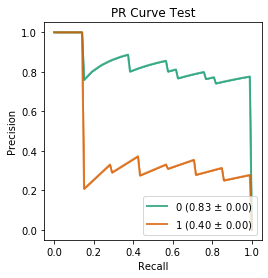

In [45]:
#plotting Log Reg results as Precision Recall curve
fig_lr = plot_result_pr(result_feat1_lr,'PR Curve Test')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioSel_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_sel, feat1_lr.predict(x_test_sel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.36


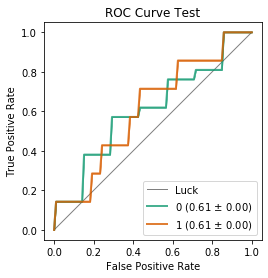

In [46]:
#plotting Log Reg results as ROC
fig_lr = plot_result_roc(result_feat1_lr,'ROC Curve Test')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioSel_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_sel, feat1_lr.predict(x_test_sel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [47]:
#testing the Random Forest full model
result_feat1_rf = pd.DataFrame(feat1_rf.predict_proba(x_test_sel))
result_feat1_rf.columns = feat1_rf.classes_
result_feat1_rf['Y_TRUE'] = y_test_sel
result_feat1_rf['CV'] = 0

Average precision-recall score: 0.27


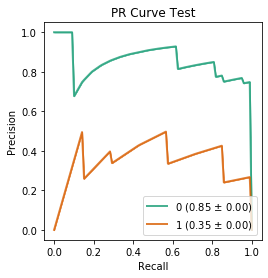

In [49]:
#plotting RF results as Precision Recall curve
fig_rf = plot_result_pr(result_feat1_rf,'PR Curve Test')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioSel_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_sel, feat1_rf.predict(x_test_sel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.39


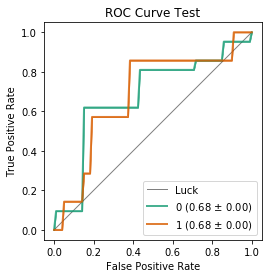

In [50]:
#plotting results as ROC
fig_rf = plot_result_roc(result_feat1_rf,'ROC Curve Test')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioSel_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_sel, feat1_rf.predict(x_test_sel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [51]:
# extracting the important features from our classifier
feat_imp2 = pd.Series(feat1_rf.feature_importances_).sort_values(ascending=False)
feat_imp2 = feat_imp2.to_frame()
feat_imp2.columns = ['imp_score']

In [52]:
# extracting the features that have a feature importance over the threshold of 0.015
top_feat2 = list(feat_imp2[feat_imp2['imp_score']>0.015].index)
#changing feature index from index location to proper feature hash val
feat2_table = feat1_table.iloc[:,top_feat2]
print('There are %d features with importance >0.015' %len(feat2_table.columns))

There are 20 features with importance >0.015


In [53]:
#export the list of full features
with open('./ml_analysis/bioRev_analysis/bio-rev-features-fsel.txt', 'w') as f:
    for item in feat2_table.columns:
        f.write("%s\n" % item)

## 3. Building Models From Further Selected Features

### 3a. CV/Train Model on G1P+G3P

In [54]:
#preparing training data for bio further select
x_train_fsel = feat2_table.loc[train_table.index]
#label encoder
y_train_fsel = []
for idx in train_table.index:
    if train_table.loc[idx,'adv_fibrosis'] == '1':
        y_train_fsel.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_fsel.append(0)
y_train_fsel = np.array(y_train_fsel)
print(x_train_fsel.shape)
print(len(y_train_fsel))

(70, 20)
70


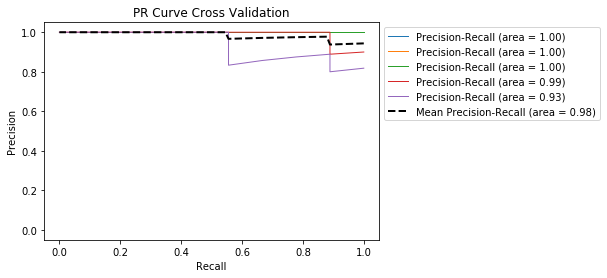

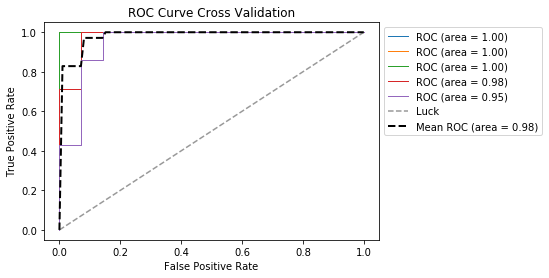

In [55]:
#plotting Precision-recall/ROC for Log Reg
fig_lr = cross_val_pr(0,x_train_fsel,y_train_fsel,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioFsel_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_fsel,y_train_fsel,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioFsel_cv_roc.pdf',bbox_inches='tight')

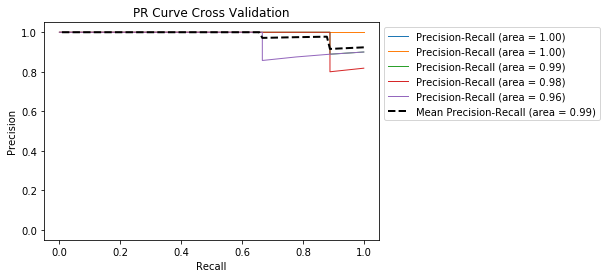

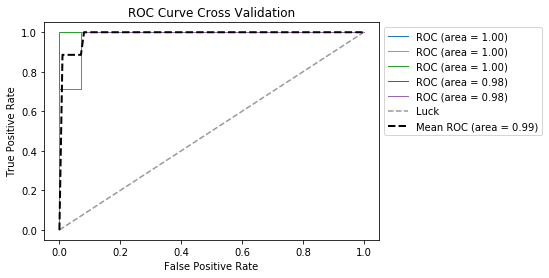

In [56]:
#plotting Precision-recall/ROC for RF
fig_rf = cross_val_pr(1,x_train_fsel,y_train_fsel,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioFsel_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_fsel,y_train_fsel,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioFsel_cv_roc.pdf',bbox_inches='tight')

In [57]:
#training Log Reg on training data
feat2_lr = LogisticRegression(random_state=0,max_iter=200)
feat2_lr.fit(x_train_fsel, y_train_fsel)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
#training RF on training data
feat2_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat2_rf.fit(x_train_fsel, y_train_fsel)
feat2_rf.oob_score_

0.9285714285714286

### 3b. Test Models on NAFLD-cirrhosis Relatives (G3R)

In [59]:
# Preparing the test data for SB
x_test_fsel = feat2_table.loc[test_table.index]
y_test_fsel = []
for idx in test_table.index:
    if test_table.loc[idx,'adv_fibrosis'] == '1':
        y_test_fsel.append(1)
    elif test_table.loc[idx,'adv_fibrosis'] == '0':
        y_test_fsel.append(0)
y_test_fsel = np.array(y_test_fsel)
print(len(x_test_fsel))
print(len(y_test_fsel))

28
28


In [60]:
#testing the logistic regression feat1 model
result_feat2_lr = pd.DataFrame(feat2_lr.predict_proba(x_test_fsel))
result_feat2_lr.columns = feat2_lr.classes_
result_feat2_lr['Y_TRUE'] = y_test_fsel
result_feat2_lr['CV'] = 0

Average precision-recall score: 0.28


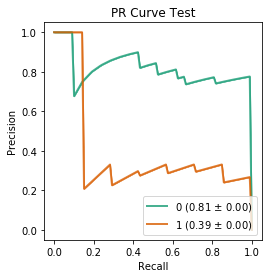

In [61]:
#plotting Log Reg results as Precision Recall curve
fig_lr = plot_result_pr(result_feat2_lr,'PR Curve Test')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioFsel_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_fsel, feat2_lr.predict(x_test_fsel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.43


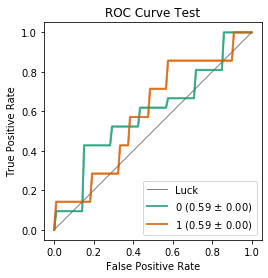

In [62]:
#plotting Log Reg results as ROC
fig_lr = plot_result_roc(result_feat2_lr,'ROC Curve Test')
fig_lr.savefig('ml_analysis/bioRev_analysis/figures/lr_bioFsel_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_fsel, feat2_lr.predict(x_test_fsel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [64]:
#testing the Random Forest full model
result_feat2_rf = pd.DataFrame(feat2_rf.predict_proba(x_test_fsel))
result_feat2_rf.columns = feat2_rf.classes_
result_feat2_rf['Y_TRUE'] = y_test_fsel
result_feat2_rf['CV'] = 0

Average precision-recall score: 0.27


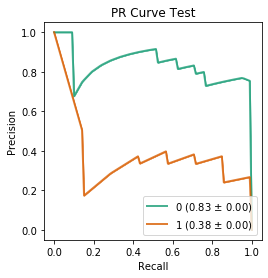

In [65]:
#plotting RF results as Precision Recall curve
fig_rf = plot_result_pr(result_feat2_rf,'PR Curve Test')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioFsel_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_fsel, feat2_rf.predict(x_test_fsel))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.39


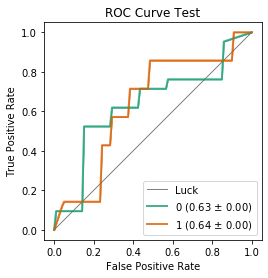

In [66]:
#plotting results as ROC
fig_rf = plot_result_roc(result_feat2_rf,'ROC Curve Test')
fig_rf.savefig('ml_analysis/bioRev_analysis/figures/rf_bioFsel_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_fsel, feat2_rf.predict(x_test_fsel))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))